In [4]:
import functools
import json
import math
import pathlib
import typing
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mpt
from mpl_toolkits.axes_grid1.axes_divider import Divider
import mpl_toolkits.axes_grid1.axes_size as asize
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns

In [5]:
# constants
# Row limit for Excel output
# technical limit of excel is slighty over 1 million
EXCEL_ROW_LIMIT = 1000000
# Format used when puting a datetime into file names.
FILE_TIME_FORMAT = "%Y%m%dT%H%M%S"

In [6]:
# input abnd output folder
# pathlib.Path has many useful functions. For instance the "/"-operator appends paths
in_folder = pathlib.Path("./in/")
config_folder = pathlib.Path("./config/")
out_folder = pathlib.Path("./out/")
# make output folder if does not exist
out_folder.mkdir(parents=True,exist_ok=True)
print(in_folder.absolute())
print(out_folder.absolute())

C:\Users\kerger\Pyhton Skripte\HSG_Sim_Datenauswertung\prevalidation\in
C:\Users\kerger\Pyhton Skripte\HSG_Sim_Datenauswertung\prevalidation\out


In [7]:
# load data
date_time_format = "%Y-%m-%d %H:%M:%S"
data_original = pd.read_excel(
    in_folder/"AFS_MW_Kanal_Regenevent589.xlsx",
    index_col=0,
    date_parser=lambda s: pd.to_datetime(s, format=date_time_format),
)
# might want to drop na-rows for testing
# data=data.dropna(how='all')
data=data_original
data = data.sort_index()
data.drop(columns=['Anomalietyp'], inplace=True)
data

,app1_conc [mg/l],app1_h [m],app1_t_water [C]
Date&Time,,,
2023-10-19 14:30:00,0.0,0.091,18.1
2023-10-19 14:30:30,0.0,0.091,18.1
2023-10-19 14:31:00,0.0,0.092,18.1
2023-10-19 14:31:30,0.0,0.092,18.1
2023-10-19 14:32:00,0.0,0.092,18.1
...,...,...,...
2023-10-19 20:35:00,0.0,0.093,18.5
2023-10-19 20:35:30,0.0,0.093,18.5
2023-10-19 20:36:00,0.0,0.093,18.5


In [8]:
# inputs
key_parameter = "app1_conc [mg/l]"
time_step = pd.to_timedelta("60s")

plot_split_freq = "1W"

In [9]:
# most test configuration comes from csv
parameters = pd.read_csv(config_folder/"parameters.csv", header=[0, 1], index_col=0)
parameters.index.name = "data_parameter"
parameters

test             physical_range             measuring_range              \
parameter           lower_limit upper_limit     lower_limit upper_limit   
data_parameter                                                            
app1_conc [mg/l]            0.0   1000000.0             NaN      6000.0   
app1_h [m]                  0.0         NaN          0.0005         5.0   
Date&Time                   NaN         NaN             NaN         NaN   
app1_t_water [C]            0.0       100.0        -20.0000        60.0   

test             calibration_range             expertise_range              \
parameter              lower_limit upper_limit     lower_limit upper_limit   
data_parameter                                                               
app1_conc [mg/l]               NaN         NaN             0.0      2500.0   
app1_h [m]                     NaN         NaN             NaN         NaN   
Date&Time                      NaN         NaN             NaN         NaN   
app1_t_water [C]               NaN         NaN            10.0        25.0   

test             gradient_range             dynamic_consistency  \
parameter           lower_limit upper_limit               other   
data_parameter                                                    
app1_conc [mg/l]        -2000.0      2000.0                 NaN   
app1_h [m]                  NaN         NaN                 NaN   
Date&Time                   NaN         NaN                 NaN   
app1_t_water [C]           -1.0         1.0                 NaN   

test             multivariate_range                                            \
parameter               lower_limit upper_limit       other other_lower_limit   
data_parameter                                                                  
app1_conc [mg/l]                NaN         NaN  app1_h [m]              0.15   
app1_h [m]                      NaN         NaN         NaN               NaN   
Date&Time                       NaN         NaN         NaN               NaN   
app1_t_water [C]                NaN         NaN         NaN               NaN   

test                               timestamp_consistency            \
parameter        other_upper_limit             time_step tolerance   
data_parameter                                                       
app1_conc [mg/l]               NaN                   NaN       NaN   
app1_h [m]                     NaN                   NaN       NaN   
Date&Time                      NaN                   30s        0s   
app1_t_water [C]               NaN                   NaN       NaN   

test             index_dupplicated missing_test  
parameter                     keep     use_test  
data_parameter                                   
app1_conc [mg/l]               NaN         True  
app1_h [m]                     NaN          NaN  
Date&Time                    False        False  
app1_t_water [C]               NaN          NaN

In [10]:
# weights for combining results from multiple parameters
default_weight = 0.5
data_parameter_weights = pd.read_csv(
    config_folder/"data_parameter_weights.csv", header=0, index_col=0
)["weight"]
data_parameter_weights

data_parameter
app1_conc [mg/l]    2.0
app1_t_water [C]    0.2
app1_h [m]          0.5
Name: weight, dtype: float64

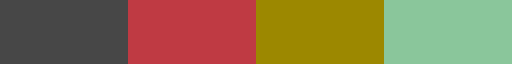

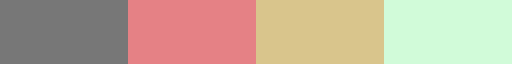

In [11]:
# Defines scores, with labels and order

score_type = pd.CategoricalDtype(
    [
        "Missing",
        "Unsuitable",
        "Doubtful",
        "Good",
    ],
    ordered=True,
)

# label when no score is defined
no_score_label = "No Test"

# numeric value of score to use for aggregating
score_number = {
    "Missing": -0.5,
    "Unsuitable": 0.0,
    "Doubtful": 0.5,
    "Good": 1.0,
}

score_number_dtype = "float16"


# go back from aggregated numbers to score labels
def number_to_score(numbers: pd.Series) -> pd.Series:
    scores = pd.Series(index=numbers.index, dtype=score_type, name="score")
    # note that nan matches no comparison
    # since nan is also the default value, we need no condition for it
    scores[numbers >= 0.9] = "Good"
    scores[(numbers < 0.9) & (numbers >= 0.25)] = "Doubtful"
    scores[numbers < 0.25] = "Unsuitable"
    scores[numbers < -0.25] = "Missing"
    return scores


# colorset for scores
score_color = {
    "Missing": "#474747",
    "Good": "#8AC69B",
    "Doubtful": "#9C8800",
    "Unsuitable": "#BF3A43",
}

# another set with brighter colors, useful if darker colors should be used for something else
score_color_bright = {
    "Missing": "#777777",
    "Unsuitable": "#E58185",
    "Doubtful": "#D9C58C",
    "Good": "#D1FBD9",
}


# colors to mpl colormap
score_colormap = mpl.colors.ListedColormap(
    [score_color[s] for s in score_type.categories]
)
score_colormap_b = mpl.colors.ListedColormap(
    [score_color_bright[s] for s in score_type.categories]
)

display(score_colormap)
display(score_colormap_b)

In [12]:
anomaly_type_letter_explanation = {
    "A": "Außerhalb Vertrauensbereich (Experten Spanne)",
    "B": "physikalisch unmögliche Werte (phys. Spanne)",
    "C": "Out-of-sensor-range values (techn. Spanne)",
    "D": "Ausfall",
    "E": "Konstanz / geringe Variabilität",
    "F": "Ausreißer",
    "G": "Gradient",
    "H": "Rauschen",
    "I": "Drift",
    "J": "Shift",
    "K": "Keine Aufzeichnung"
}

anomaly_dtype = pd.CategoricalDtype(
    anomaly_type_letter_explanation.keys(),
    ordered=False,
)

In [13]:
# show categories to codes translation
score_codes = pd.Series(
    data=[None] + list(score_type.categories),
    index=[None] + list(score_type.categories),
    dtype=score_type,
).cat.codes
score_codes

NaN          -1
Missing       0
Unsuitable    1
Doubtful      2
Good          3
dtype: int8

In [14]:
TestResult = typing.NamedTuple(
    "TestResult", [("score", pd.DataFrame), ("anom_type", pd.DataFrame)]
)


def bool_value_map(
    bool_df: pd.DataFrame, false_value, true_value, dtype
) -> pd.DataFrame:
    """Translates a boolean Dataframe to a Dataframe with bools replaced by passed values."""
    scores = pd.DataFrame(
        data=true_value, index=bool_df.index, columns=bool_df.columns, dtype=dtype
    )
    return scores.where(bool_df, other=false_value)


def bool_to_test_result(
    bool_df: pd.DataFrame, bad_score: float, anom_type: str
) -> TestResult:
    """Converts boolean DataFrame to TestResult. Assume that false indicates a failed test and sets bad_score/anom_type for cells with false."""
    return TestResult(
        bool_value_map(bool_df, bad_score, score_number["Good"], score_number_dtype),
        bool_value_map(bool_df, anom_type, None, anomaly_dtype),
    )


def filter_cols(test_func):
    """filter the columns of date before executing the test, so that only columns where a parameter is configured are passed to the test.
    intended to be use as a decorator (write "@filter_cols" before the function definition),
    therefore filter_cols returns a modified function and not the result of the function
    !! assumes that the test is called with data as only positional argument and the parameters as keyword argument
    """

    # this ensures that the functions resulting from the wrapper keeps the original signature
    @functools.wraps(test_func)
    def wrapper_filter(data, **parameters):
        # take all columns where some arg is not nan
        cols = pd.Index([], dtype=data.columns.dtype)
        for param in parameters.values():
            cols = cols.union(param.dropna().index)
        # parameters for index may be configured,
        # but it cannot be used like a column name and is included anyway.
        # cols may be empty, in this case data[cols] contains only the index.
        # This may seem odd, but is everything needed.
        data_filtered = data.loc[:, cols.drop(data.index.name, errors="ignore")]
        # for the columns the index should not be dropped
        # the test function is expected to handle this case
        kwargs_filtered = {name: values[cols] for name, values in parameters.items()}
        return test_func(data_filtered, **kwargs_filtered)

    return wrapper_filter


def calc_gradient(data: pd.DataFrame) -> pd.DataFrame:
    """calculate the gradient of all columns relative to timestep (global variable)"""
    # calculate gradient, relative to timestep
    # diff gives change to previous value
    # division by timestep since configured values are expected to be relative to timestep, also makes the timedelta into a float
    # / matches the columns by default, use divide with keyword where index needs to be matched.
    return data.diff().divide(data.index.to_series().diff() / time_step, axis="index")

In [18]:
# test functions
# to allow tests over any columns, all the data is passed in the data argument
# / in args: all previous args can only be positional
# * in args: all following args can only be keyword args

@filter_cols
def range_test_bool(
    data: pd.DataFrame,
    /,
    *,
    lower_limit: pd.Series,
    upper_limit: pd.Series,
) -> pd.DataFrame:
    """Test if values are in range. lower/upper_limit should define limits per column. Returns boolean DataFrame"""  
    # count nan as no limit, therefore use or pd.isna
    lower_inclusive = pd.Series(index=lower_limit.index, data=True)
    upper_inclusive = pd.Series(index=upper_limit.index, data=True)
    if not is_numeric_dtype(lower_limit):
        # only modify a copy of the argument to not cause side effects
        # fill na with "" since nan is converted to literal string "nan", which to_numeric does not cast to nan
        lower_limit = lower_limit.copy().fillna("")
        lower_limit = lower_limit.astype(str)
        lower_inclusive = ~(lower_limit.str.strip().str.startswith("("))
        lower_limit = pd.to_numeric(
            lower_limit.str.strip().str.removeprefix("(").str.removeprefix("["),
        )
    if not is_numeric_dtype(upper_limit):
        # only modify a copy of the argument to not cause side effects
        # fill na with "" since nan is converted to literal string "nan", which to_numeric does not cast to nan
        upper_limit = upper_limit.copy().fillna("")
        upper_limit = upper_limit.astype(str)
        upper_inclusive = ~(upper_limit.str.strip().str.endswith(")"))
        upper_limit = pd.to_numeric(
            upper_limit.str.strip().str.removesuffix(")").str.removesuffix("]")
        )
    return (
        (data >= lower_limit)
        | (lower_inclusive & (data == lower_limit))
        | pd.isna(lower_limit)
    ) & (
        (data <= upper_limit)
        | (upper_inclusive & (data == upper_limit))
        | pd.isna(upper_limit)
    )

def range_test_factory(score:float,anom:str) -> typing.Callable[...,TestResult]:
    """Returns a range test function, where values outside the range are assigned the specified score and anomaly type."""
    def range_test(
        data: pd.DataFrame,/,*, lower_limit: pd.Series, upper_limit: pd.Series
    ) -> TestResult:
        return bool_to_test_result(
            range_test_bool(data, lower_limit=lower_limit, upper_limit=upper_limit),
            score,
            anom,
        )
    return range_test

@filter_cols
def gradient_range_test(
    data: pd.DataFrame,/,*, lower_limit: pd.Series, upper_limit: pd.Series
) -> TestResult:
    """Check whether gradients are between the limits. Limits are relative to time_step (global variable)"""
    gradient = calc_gradient(data)
    # count nan as no limit, therefore use or pd.isna
    gradient_ok = range_test_bool(gradient,lower_limit=lower_limit,upper_limit=upper_limit)
    return bool_to_test_result(gradient_ok, score_number["Doubtful"], "G")


@filter_cols
def timestamp_consistency(
    data: pd.DataFrame,/,*, time_step: pd.Series, tolerance: pd.Series
) -> TestResult:
    """Check whether times differences from line to line are equal to time_step (global variable)"""
    if (time_step.dropna().index != data.index.name).any() or (
        tolerance.dropna().index != data.index.name
    ).any():
        # Only applied to index for now. Might be useful for other columns?
        raise NotImplementedError("Only implemented for index")
    time_step = pd.to_timedelta(time_step)
    time_stamp_deviation =  (pd.DataFrame(data.index.to_series()).diff() - time_step).abs()
    time_stamp_consistent = time_stamp_deviation <= tolerance
    # first diff is na, since there is no previous timestamp. But this should not be marked as doubtful
    time_stamp_consistent.iloc[0] = True
    return bool_to_test_result(
        time_stamp_consistent,
        score_number["Doubtful"],
        "K",
    )


@filter_cols
def missing_test(data: pd.DataFrame,/,*, use_test: pd.Series) -> TestResult:
    """Check for missing values (nan)"""
    # ok if not na or test is not applied. use_test==True so that NaN -> False
    nan_ok = data.notna() | (use_test.drop(data.index.name,errors='ignore') == False)
    # also include index, if so configured
    if data.index.name in use_test.index and use_test[data.index.name]==True:
        nan_ok[data.index.name]=data.index.notna()
    return bool_to_test_result(
        nan_ok,
        score_number["Unsuitable"],
        "D",
    )


@filter_cols
def index_dupplicated(data: pd.DataFrame,/,*, keep: pd.Series) -> TestResult:
    """
    Check for dupplicated index entries
    keep: "All":No dupplicates marked; "False": All duplicates marked; "first"/"last": first/last occurence not marked
    """
    # TODO check anomaly type
    if (keep.dropna().index != data.index.name).any():
        # only makes sense for index
        raise ValueError("Can only be applied to index")
    keep = keep[data.index.name]
    if keep == "All" or keep == None or keep == np.nan:
        return pd.DataFrame(data=True, index=data.index, columns=[data.index.name])
    if keep == "False":
        keep = False
    return bool_to_test_result(
        pd.DataFrame(
            data=~data.index.duplicated(keep=keep),
            index=data.index,
            columns=[data.index.name],
        ),
        score_number["Unsuitable"],
        "K",
    )


def multivariate_range(
    data: pd.DataFrame,
    /,
    *,
    lower_limit: pd.Series,
    upper_limit: pd.Series,
    other: pd.Series,
    other_lower_limit: pd.Series,
    other_upper_limit: pd.Series,
) -> TestResult:
    """Used when the data parameter data is doubtful when other parameter is outside a specific range.
    other parameter not in range: Doubtful, type K,
    else good.
    results are written in a column defined by the index.
    other should be a column name. exclusive limits can be defined by using "(x" or "y)".
    """
    # other...limit without other makes no sense, raise error
    if (other.isna() & (other_lower_limit.notna() | other_upper_limit.notna())).any():
        raise ValueError("a limit for other is configured, but other is not specified.")
    other = other.dropna()
    other_low = other_lower_limit[other.index].copy()
    other_up = other_upper_limit[other.index].copy()
    # limits in range_test compare to the columns defined by the index,
    # here this needs to be other
    other_low.index = other
    other_up.index = other    
    other_in_range = range_test_bool(data, lower_limit=other_low, upper_limit=other_up)
    scores = pd.DataFrame(
        data=score_number["Good"],
        index=data.index,
        columns=other.index,
        dtype=score_number_dtype,
    )
    types = pd.DataFrame(
        data=None, index=data.index, columns=other.index, dtype=anomaly_dtype
    )

    return bool_to_test_result(
        other_in_range,
        score_number["Doubtful"],
        "K",
    )

def dynamic_consistency(data: pd.DataFrame,/,*, other: pd.Series) -> TestResult:
    """Checks if gradient sign of a column is equal to at least one sign from a column defined by other.
    other is expected as a json list."""
    other = other.dropna().apply(json.loads).explode()
    grads_sign = np.sign(calc_gradient(data))
    gi = grads_sign[other.index]
    go = grads_sign[other]
    go.columns = gi.columns
    comp = gi == go
    return bool_to_test_result(
        comp.T.groupby(other.index).any().T, score_number["Doubtful"], "B"
    )

@filter_cols
def global_outliers(data: pd.DataFrame,/,*, range_mult: pd.Series) -> TestResult:
    mean = data.mean(axis='index')
    std = data.std(axis='index')
    range_ok = range_test_bool(data,lower_limit=mean-std*range_mult,upper_limit=mean+std*range_mult)
    return bool_to_test_result(range_ok,score_number["Doubtful"],"F")


In [19]:
# assings a function to a text-key
# this allows easy configuration of the tests from text-files

text_function: typing.Dict[str, typing.Callable[..., TestResult]] = {
    "gradient_range": gradient_range_test,
    "timestamp_consistency": timestamp_consistency,
    "missing_test": missing_test,
    "index_dupplicated": index_dupplicated,
    "dynamic_consistency": dynamic_consistency,
    "multivariate_range": multivariate_range,
    "global_outliers": global_outliers,
}


# range tests are mostly the same, configure those with a dict of form name ->(bad score,anomaly type)
range_test_config = {
    "physical_range": (score_number["Unsuitable"], "B"),
    "measuring_range": (score_number["Unsuitable"], "C"),
    "calibration_range": (score_number["Doubtful"], "C"),
    "expertise_range": (score_number["Doubtful"], "A"),
}
# puts individual range test functions into text_funtion.
# the functions are created from the factory funtions, creating it here could be problematic, because score and anom type would always
# the value from the last loop execution. See https://docs.python-guide.org/writing/gotchas/#late-binding-closures
text_function |= {
    f_name: range_test_factory(score,anom)
    for f_name, (score, anom) in range_test_config.items()
}

In [20]:
# first calculate tests for all parameters and all tests
test_results: typing.Dict[str, TestResult] = {}
# loop over all tests where parameters are configured
for test in parameters.columns.get_level_values("test").unique():
    print("Test: " + test)
    # make a dict of the form parameter->series
    # where series is a pandas series with data parameters as index and the test parameters as values
    test_args: typing.Dict[str, typing.Any] = parameters.xs(
        test, axis="columns", level="test"
    ).to_dict("series")
    # text_function contains functions as value, which we can call with ()
    # ** unrolls test_args, the dict is applied like named arguments
    # the test function is expected to handle the test for all parameters at once
    test_results[test] = text_function[test](data, **test_args)
test_scores = pd.concat({t: rs.score for t, rs in test_results.items()}, axis="columns")
test_scores.columns.names = ["test", "data_parameter"]
test_anom_types = pd.concat(
    {t: rs.anom_type for t, rs in test_results.items()}, axis="columns"
)
test_anom_types.columns.names = ["test", "data_parameter"]
test_scores[test_scores.min("columns") < 1]

Test: physical_range
Test: measuring_range
Test: calibration_range
Test: expertise_range
Test: gradient_range
Test: dynamic_consistency
Test: multivariate_range
Test: timestamp_consistency
Test: index_dupplicated
Test: missing_test


test                  physical_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              1.0        1.0              1.0   
2023-10-19 14:30:30              1.0        1.0              1.0   
2023-10-19 14:31:00              1.0        1.0              1.0   
2023-10-19 14:31:30              1.0        1.0              1.0   
2023-10-19 14:32:00              1.0        1.0              1.0   
...                              ...        ...              ...   
2023-10-19 20:35:00              1.0        1.0              1.0   
2023-10-19 20:35:30              1.0        1.0              1.0   
2023-10-19 20:36:00              1.0        1.0              1.0   
2023-10-19 20:36:30              1.0        1.0              1.0   
2023-10-19 20:37:00              1.0        1.0              1.0   

test                 measuring_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              1.0        1.0              1.0   
2023-10-19 14:30:30              1.0        1.0              1.0   
2023-10-19 14:31:00              1.0        1.0              1.0   
2023-10-19 14:31:30              1.0        1.0              1.0   
2023-10-19 14:32:00              1.0        1.0              1.0   
...                              ...        ...              ...   
2023-10-19 20:35:00              1.0        1.0              1.0   
2023-10-19 20:35:30              1.0        1.0              1.0   
2023-10-19 20:36:00              1.0        1.0              1.0   
2023-10-19 20:36:30              1.0        1.0              1.0   
2023-10-19 20:37:00              1.0        1.0              1.0   

test                 expertise_range                    gradient_range  \
data_parameter      app1_conc [mg/l] app1_t_water [C] app1_conc [mg/l]   
Date&Time                                                                
2023-10-19 14:30:00              1.0              1.0              0.5   
2023-10-19 14:30:30              1.0              1.0              1.0   
2023-10-19 14:31:00              1.0              1.0              1.0   
2023-10-19 14:31:30              1.0              1.0              1.0   
2023-10-19 14:32:00              1.0              1.0              1.0   
...                              ...              ...              ...   
2023-10-19 20:35:00              1.0              1.0              1.0   
2023-10-19 20:35:30              1.0              1.0              1.0   
2023-10-19 20:36:00              1.0              1.0              1.0   
2023-10-19 20:36:30              1.0              1.0              1.0   
2023-10-19 20:37:00              1.0              1.0              1.0   

test                                 multivariate_range timestamp_consistency  \
data_parameter      app1_t_water [C]         app1_h [m]             Date&Time   
Date&Time                                                                       
2023-10-19 14:30:00              0.5                0.5                   1.0   
2023-10-19 14:30:30              1.0                0.5                   1.0   
2023-10-19 14:31:00              1.0                0.5                   1.0   
2023-10-19 14:31:30              1.0                0.5                   1.0   
2023-10-19 14:32:00              1.0                0.5                   1.0   
...                              ...                ...                   ...   
2023-10-19 20:35:00              1.0                0.5                   1.0   
2023-10-19 20:35:30              1.0                0.5                   1.0   
2023-10-19 20:36:00              1.0                0.5                   1.0   
2023-10-19 20:36:30              1.0                0.5                   1.0   
2023

## Append the anomaly types from the prevalidation to the original data

In [21]:
# Combine all the letters into a new column
test_anom_types['Anomaly_prevalidation'] = test_anom_types.apply(lambda row: ''.join(str(x) for x in row if isinstance(x, str)), axis=1)
test_anom_types

test                  physical_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              NaN        NaN              NaN   
2023-10-19 14:30:30              NaN        NaN              NaN   
2023-10-19 14:31:00              NaN        NaN              NaN   
2023-10-19 14:31:30              NaN        NaN              NaN   
2023-10-19 14:32:00              NaN        NaN              NaN   
...                              ...        ...              ...   
2023-10-19 20:35:00              NaN        NaN              NaN   
2023-10-19 20:35:30              NaN        NaN              NaN   
2023-10-19 20:36:00              NaN        NaN              NaN   
2023-10-19 20:36:30              NaN        NaN              NaN   
2023-10-19 20:37:00              NaN        NaN              NaN   

test                 measuring_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              NaN        NaN              NaN   
2023-10-19 14:30:30              NaN        NaN              NaN   
2023-10-19 14:31:00              NaN        NaN              NaN   
2023-10-19 14:31:30              NaN        NaN              NaN   
2023-10-19 14:32:00              NaN        NaN              NaN   
...                              ...        ...              ...   
2023-10-19 20:35:00              NaN        NaN              NaN   
2023-10-19 20:35:30              NaN        NaN              NaN   
2023-10-19 20:36:00              NaN        NaN              NaN   
2023-10-19 20:36:30              NaN        NaN              NaN   
2023-10-19 20:37:00              NaN        NaN              NaN   

test                 expertise_range                    gradient_range  \
data_parameter      app1_conc [mg/l] app1_t_water [C] app1_conc [mg/l]   
Date&Time                                                                
2023-10-19 14:30:00              NaN              NaN                G   
2023-10-19 14:30:30              NaN              NaN              NaN   
2023-10-19 14:31:00              NaN              NaN              NaN   
2023-10-19 14:31:30              NaN              NaN              NaN   
2023-10-19 14:32:00              NaN              NaN              NaN   
...                              ...              ...              ...   
2023-10-19 20:35:00              NaN              NaN              NaN   
2023-10-19 20:35:30              NaN              NaN              NaN   
2023-10-19 20:36:00              NaN              NaN              NaN   
2023-10-19 20:36:30              NaN              NaN              NaN   
2023-10-19 20:37:00              NaN              NaN              NaN   

test                                 multivariate_range timestamp_consistency  \
data_parameter      app1_t_water [C]         app1_h [m]             Date&Time   
Date&Time                                                                       
2023-10-19 14:30:00                G                  K                   NaN   
2023-10-19 14:30:30              NaN                  K                   NaN   
2023-10-19 14:31:00              NaN                  K                   NaN   
2023-10-19 14:31:30              NaN                  K                   NaN   
2023-10-19 14:32:00              NaN                  K                   NaN   
...                              ...                ...                   ...   
2023-10-19 20:35:00              NaN                  K                   NaN   
2023-10-19 20:35:30              NaN                  K                   NaN   
2023-10-19 20:36:00              NaN                  K                   NaN   
2023-10-19 20:36:30              NaN                  K                   NaN   
2023

In [22]:
# New DataFrame to merge with
data_to_merge = pd.DataFrame({'Anomaly_prevalidation': test_anom_types['Anomaly_prevalidation']})

# Function to remove duplicate letters from a string
def remove_duplicates(s):
    return ''.join(sorted(set(s), key=s.index))

# Apply the function to the text column
data_to_merge['Anomaly_prevalidation'] = data_to_merge['Anomaly_prevalidation'].apply(remove_duplicates)


In [23]:
# Merge with the original DataFrame based on 'Date&Time' index
merged_df = pd.merge(data_original, data_to_merge, left_index=True, right_index=True, how='left')
# Result to csv
merged_df.to_csv(out_folder/"anomaly_type_prevalidation.csv")
merged_df


,app1_conc [mg/l],app1_h [m],app1_t_water [C],Anomalietyp,Anomaly_prevalidation
Date&Time,,,,,
2023-10-19 14:30:00,0.0,0.091,18.1,K,GK
2023-10-19 14:30:30,0.0,0.091,18.1,K,K
2023-10-19 14:31:00,0.0,0.092,18.1,K,K
2023-10-19 14:31:30,0.0,0.092,18.1,K,K
2023-10-19 14:32:00,0.0,0.092,18.1,K,K
...,...,...,...,...,...
2023-10-19 20:35:00,0.0,0.093,18.5,K,K
2023-10-19 20:35:30,0.0,0.093,18.5,K,K
2023-10-19 20:36:00,0.0,0.093,18.5,K,K


## Further evaluation of results

In [59]:
# now combine tests
# uses some hardcoded rules and the weights
# 1) For the keyparameter if one test is U the result is Unsuitable

is_key_unsuitable = (
    test_scores.xs(key_parameter, axis="columns", level="data_parameter") == 0
)
is_key_unsuitable = is_key_unsuitable.any(axis="columns")
# 2) If all parameterresults are good the result is good
# TODO Check: this should be implicit in weighted method?

# 3) If all keyparameterresults are good but we habe doubtful
# data in the other parameters the result is good

is_key_all_good = (
    test_scores.xs(key_parameter, axis="columns", level="data_parameter") == 1
)
is_key_all_good = is_key_all_good.all(axis="columns")
is_none_unsuitable = (test_scores > 0).all(axis="columns")
# 4) If keyparameters and other parameters are doubtful/unsuitable we calcualte a mean of the "doubtfulness".
# For that we assume that G=1, D=0,5, U=0. Then we calculate the mean for the keyparamter and the other parameters
# (here we weight them to each other with a factor) and then combine then with another weight factor.

# TODO missing weights? For now fill with .5
data_params = test_scores.columns.get_level_values(1).unique()
# fill missing
data_parameter_weights = data_parameter_weights.reindex(
    data_params, fill_value=default_weight
)
# put into shape of columns from test data, otherwise pandas would not understand that data_parameter needs to be matched.
data_parameter_weights = data_parameter_weights.reindex(
    test_scores.columns, level="data_parameter"
)

# weighted average.
test_result_avg = test_scores * data_parameter_weights
test_result_avg = test_result_avg.sum(axis="columns") / data_parameter_weights.sum()
# combine all rules
test_aggregated = number_to_score(test_result_avg)
test_aggregated[is_key_all_good & is_none_unsuitable] = "Good"
test_aggregated[is_key_unsuitable] = "Unsuitable"
test_aggregated

Date&Time
2023-10-19 14:30:00    Doubtful
2023-10-19 14:30:30        Good
2023-10-19 14:31:00        Good
2023-10-19 14:31:30        Good
2023-10-19 14:32:00        Good
                         ...   
2023-10-19 20:35:00        Good
2023-10-19 20:35:30        Good
2023-10-19 20:36:00        Good
2023-10-19 20:36:30        Good
2023-10-19 20:37:00        Good
Name: score, Length: 736, dtype: category
Categories (4, object): ['Missing' < 'Unsuitable' < 'Doubtful' < 'Good']

In [60]:
# set code for missing times to Missing
equidistant_datetime = pd.Index(
    pd.date_range(
        start=test_aggregated.index.min(),
        end=test_aggregated.index.max(),
        freq=time_step,
    ),
    name=test_aggregated.index.name,
)
missing_datetime = equidistant_datetime.difference(test_aggregated.index)
# display(missing_datetime)
test_aggregated = pd.concat(
    [
        test_aggregated,
        pd.Series(
            index=missing_datetime,
            data="Missing",
            name=test_aggregated.name,
            dtype=score_type,
        ),
    ]
).sort_index()
# make dataframes for complete test results
full_test_scores = test_scores.transform(number_to_score)
# add missing values times here to
# aggregation does not work with missing values, so do it after aggregation
full_test_scores = pd.concat(
    [
        full_test_scores,
        pd.DataFrame(
            index=missing_datetime,
            data="Missing",
            columns=full_test_scores.columns,
            dtype=score_type,
        ),
    ]
).sort_index()
full_test_scores[("aggregated","")]=test_aggregated
display(full_test_scores)
full_test_codes = full_test_scores.copy()
for col in full_test_scores.columns:
    full_test_codes[col] = full_test_scores[col].cat.codes

test                  physical_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00             Good       Good             Good   
2023-10-19 14:30:30             Good       Good             Good   
2023-10-19 14:31:00             Good       Good             Good   
2023-10-19 14:31:30             Good       Good             Good   
2023-10-19 14:32:00             Good       Good             Good   
...                              ...        ...              ...   
2023-10-19 20:35:00             Good       Good             Good   
2023-10-19 20:35:30             Good       Good             Good   
2023-10-19 20:36:00             Good       Good             Good   
2023-10-19 20:36:30             Good       Good             Good   
2023-10-19 20:37:00             Good       Good             Good   

test                 measuring_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00             Good       Good       Unsuitable   
2023-10-19 14:30:30             Good       Good       Unsuitable   
2023-10-19 14:31:00             Good       Good       Unsuitable   
2023-10-19 14:31:30             Good       Good       Unsuitable   
2023-10-19 14:32:00             Good       Good       Unsuitable   
...                              ...        ...              ...   
2023-10-19 20:35:00             Good       Good       Unsuitable   
2023-10-19 20:35:30             Good       Good       Unsuitable   
2023-10-19 20:36:00             Good       Good       Unsuitable   
2023-10-19 20:36:30             Good       Good       Unsuitable   
2023-10-19 20:37:00             Good       Good       Unsuitable   

test                 expertise_range   gradient_range multivariate_range  \
data_parameter      app1_conc [mg/l] app1_conc [mg/l]   app1_conc [mg/l]   
Date&Time                                                                  
2023-10-19 14:30:00         Doubtful         Doubtful               Good   
2023-10-19 14:30:30         Doubtful             Good               Good   
2023-10-19 14:31:00         Doubtful             Good               Good   
2023-10-19 14:31:30         Doubtful             Good               Good   
2023-10-19 14:32:00         Doubtful             Good               Good   
...                              ...              ...                ...   
2023-10-19 20:35:00         Doubtful             Good               Good   
2023-10-19 20:35:30         Doubtful             Good               Good   
2023-10-19 20:36:00         Doubtful             Good               Good   
2023-10-19 20:36:30         Doubtful             Good               Good   
2023-10-19 20:37:00         Doubtful             Good               Good   

test                timestamp_consistency index_dupplicated     missing_test  \
data_parameter                  Date&Time         Date&Time app1_conc [mg/l]   
Date&Time                                                                      
2023-10-19 14:30:00                  Good              Good             Good   
2023-10-19 14:30:30                  Good              Good             Good   
2023-10-19 14:31:00                  Good              Good             Good   
2023-10-19 14:31:30                  Good              Good             Good   
2023-10-19 14:32:00                  Good              Good             Good   
...                                   ...               ...              ...   
2023-10-19 20:35:00                  Good              Good             Good   
2023-10-19 20:35:30                  Good              Good             Good   
2023-10-19 20:36:00                  Good              Good             Good   
2023-10-19 20:36:30                  Good              Good          

In [61]:
# results to csv
full_test_scores.to_csv(out_folder/"test_scores.csv")
test_anom_types.to_csv(out_folder/"test_anomaly_types.csv")

In [62]:
display("All")
display(full_test_scores.melt()["value"].value_counts())
for col in full_test_scores.columns:
    display(col)
    display(full_test_scores[col].value_counts())

'All'

Good          8275
Unsuitable     745
Doubtful       548
Name: value, dtype: int64

('physical_range', 'app1_conc [mg/l]')

Good          735
Unsuitable      1
Missing         0
Doubtful        0
Name: (physical_range, app1_conc [mg/l]), dtype: int64

('physical_range', 'app1_h [m]')

Good          735
Unsuitable      1
Missing         0
Doubtful        0
Name: (physical_range, app1_h [m]), dtype: int64

('physical_range', 'app1_t_water [C]')

Good          735
Unsuitable      1
Missing         0
Doubtful        0
Name: (physical_range, app1_t_water [C]), dtype: int64

('measuring_range', 'app1_conc [mg/l]')

Good          734
Unsuitable      2
Missing         0
Doubtful        0
Name: (measuring_range, app1_conc [mg/l]), dtype: int64

('measuring_range', 'app1_h [m]')

Good          735
Unsuitable      1
Missing         0
Doubtful        0
Name: (measuring_range, app1_h [m]), dtype: int64

('measuring_range', 'app1_t_water [C]')

Unsuitable    736
Missing         0
Doubtful        0
Good            0
Name: (measuring_range, app1_t_water [C]), dtype: int64

('expertise_range', 'app1_conc [mg/l]')

Doubtful      531
Good          205
Missing         0
Unsuitable      0
Name: (expertise_range, app1_conc [mg/l]), dtype: int64

('gradient_range', 'app1_conc [mg/l]')

Good          725
Doubtful       11
Missing         0
Unsuitable      0
Name: (gradient_range, app1_conc [mg/l]), dtype: int64

('multivariate_range', 'app1_conc [mg/l]')

Good          736
Missing         0
Unsuitable      0
Doubtful        0
Name: (multivariate_range, app1_conc [mg/l]), dtype: int64

('timestamp_consistency', 'Date&Time')

Good          734
Doubtful        2
Missing         0
Unsuitable      0
Name: (timestamp_consistency, Date&Time), dtype: int64

('index_dupplicated', 'Date&Time')

Good          736
Missing         0
Unsuitable      0
Doubtful        0
Name: (index_dupplicated, Date&Time), dtype: int64

('missing_test', 'app1_conc [mg/l]')

Good          735
Unsuitable      1
Missing         0
Doubtful        0
Name: (missing_test, app1_conc [mg/l]), dtype: int64

('aggregated', '')

Good          730
Doubtful        4
Unsuitable      2
Missing         0
Name: (aggregated, ), dtype: int64

Good          730
Doubtful        4
Unsuitable      2
Missing         0
Name: score, dtype: int64

Good          0.991848
Doubtful      0.005435
Unsuitable    0.002717
Missing       0.000000
Name: score, dtype: float64

<AxesSubplot:ylabel='score'>

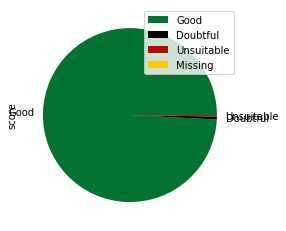

In [63]:
# summary: values counts and pie chart
display(test_aggregated.value_counts(dropna=False))
display(test_aggregated.value_counts(dropna=False) / len(test_aggregated))
test_aggregated.value_counts(dropna=False).plot.pie(legend=True, colormap=cm_fiw_traffic_lights)

In [64]:
# print parameter header, useful for making a parameters.csv
import inspect

tests = [
    "data_parameter",
]
args = [
    "name",
]
for t in text_function.keys():
    for p in inspect.signature(text_function[t]).parameters:
        if p != "data":
            tests.append(t)
            args.append(p)
print(",".join(tests))
print(",".join(args))

data_parameter,gradient_range,gradient_range,timestamp_consistency,timestamp_consistency,missing_test,index_dupplicated,dynamic_consistency,multivariate_range,multivariate_range,multivariate_range,multivariate_range,multivariate_range,global_outliers,physical_range,physical_range,measuring_range,measuring_range,calibration_range,calibration_range,expertise_range,expertise_range
name,lower_limit,upper_limit,time_step,tolerance,use_test,keep,other,lower_limit,upper_limit,other,other_lower_limit,other_upper_limit,range_mult,lower_limit,upper_limit,lower_limit,upper_limit,lower_limit,upper_limit,lower_limit,upper_limit


In [68]:
test_anom_types

test                  physical_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              NaN        NaN              NaN   
2023-10-19 14:30:30              NaN        NaN              NaN   
2023-10-19 14:31:00              NaN        NaN              NaN   
2023-10-19 14:31:30              NaN        NaN              NaN   
2023-10-19 14:32:00              NaN        NaN              NaN   
...                              ...        ...              ...   
2023-10-19 20:35:00              NaN        NaN              NaN   
2023-10-19 20:35:30              NaN        NaN              NaN   
2023-10-19 20:36:00              NaN        NaN              NaN   
2023-10-19 20:36:30              NaN        NaN              NaN   
2023-10-19 20:37:00              NaN        NaN              NaN   

test                 measuring_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              NaN        NaN                C   
2023-10-19 14:30:30              NaN        NaN                C   
2023-10-19 14:31:00              NaN        NaN                C   
2023-10-19 14:31:30              NaN        NaN                C   
2023-10-19 14:32:00              NaN        NaN                C   
...                              ...        ...              ...   
2023-10-19 20:35:00              NaN        NaN                C   
2023-10-19 20:35:30              NaN        NaN                C   
2023-10-19 20:36:00              NaN        NaN                C   
2023-10-19 20:36:30              NaN        NaN                C   
2023-10-19 20:37:00              NaN        NaN                C   

test                 expertise_range   gradient_range multivariate_range  \
data_parameter      app1_conc [mg/l] app1_conc [mg/l]   app1_conc [mg/l]   
Date&Time                                                                  
2023-10-19 14:30:00                A                G                NaN   
2023-10-19 14:30:30                A              NaN                NaN   
2023-10-19 14:31:00                A              NaN                NaN   
2023-10-19 14:31:30                A              NaN                NaN   
2023-10-19 14:32:00                A              NaN                NaN   
...                              ...              ...                ...   
2023-10-19 20:35:00                A              NaN                NaN   
2023-10-19 20:35:30                A              NaN                NaN   
2023-10-19 20:36:00                A              NaN                NaN   
2023-10-19 20:36:30                A              NaN                NaN   
2023-10-19 20:37:00                A              NaN                NaN   

test                timestamp_consistency index_dupplicated     missing_test  
data_parameter                  Date&Time         Date&Time app1_conc [mg/l]  
Date&Time                                                                     
2023-10-19 14:30:00                   NaN               NaN              NaN  
2023-10-19 14:30:30                   NaN               NaN              NaN  
2023-10-19 14:31:00                   NaN               NaN              NaN  
2023-10-19 14:31:30                   NaN               NaN              NaN  
2023-10-19 14:32:00                   NaN               NaN              NaN  
...                                   ...               ...              ...  
2023-10-19 20:35:00                   NaN               NaN              NaN  
2023-10-19 20:35:30                   NaN               NaN              NaN  
2023-10-19 20:36:00                   NaN               NaN              NaN  
2023-10-19 20:36:30                   NaN               NaN              NaN  
20

In [69]:
# insert -1 as starting value. If it appears after filling the data something went wrong
anom_vcounts = pd.DataFrame(data=-1,index = anomaly_dtype.categories.union(["None"],sort=False),columns=test_anom_types.columns.union([("Any","")]),dtype=int)
for at in anomaly_dtype.categories:
    # columns for each test: number of times where the test has the anomaly type
    anom_vcounts.loc[at,:] = (test_anom_types==at).sum(axis="index")
    # "Any" column : number of times where at least one test has the anomaly type
    anom_vcounts.loc[at,("Any","")] = (test_anom_types==at).any(axis="columns").sum(axis="index")
# Number of times where No anomaly occurs for this test
anom_vcounts.loc["None",test_anom_types.columns] = test_anom_types.isna().sum(axis="index")
# Number of times where No anomaly occurs for at least  one test
anom_vcounts.loc["None",("Any","")] =  test_anom_types.isna().any(axis="columns").sum(axis="index")
anom_vcounts.to_csv(out_folder/"anom_vcounts.csv")
assert (anom_vcounts!=-1).all(axis=None), "Some has no value assigned"
anom_vcounts


test              Any  expertise_range   gradient_range index_dupplicated  \
data_parameter        app1_conc [mg/l] app1_conc [mg/l]         Date&Time   
A               531.0              531                0                 0   
B                 1.0                0                0                 0   
C               736.0                0                0                 0   
D                 1.0                0                0                 0   
E                 0.0                0                0                 0   
F                 0.0                0                0                 0   
G                11.0                0               11                 0   
H                 0.0                0                0                 0   
I                 0.0                0                0                 0   
J                 0.0                0                0                 0   
K                 2.0                0                0                 0   
None            736.0              205              725               736   

test            measuring_range                                 missing_test  \
data_parameter app1_conc [mg/l] app1_h [m] app1_t_water [C] app1_conc [mg/l]   
A                             0          0                0                0   
B                             0          0                0                0   
C                             2          1              736                0   
D                             0          0                0                1   
E                             0          0                0                0   
F                             0          0                0                0   
G                             0          0                0                0   
H                             0          0                0                0   
I                             0          0                0                0   
J                             0          0                0                0   
K                             0          0                0                0   
None                        734        735                0              735   

test           multivariate_range   physical_range             \
data_parameter   app1_conc [mg/l] app1_conc [mg/l] app1_h [m]   
A                               0                0          0   
B                               0                1          1   
C                               0                0          0   
D                               0                0          0   
E                               0                0          0   
F                               0                0          0   
G                               0                0          0   
H                               0                0          0   
I                               0                0          0   
J                               0                0          0   
K                               0                0          0   
None                          736              735        735   

test                            timestamp_consistency  
data_parameter app1_t_water [C]             Date&Time  
A                             0                     0  
B                             1                     0  
C                             0                     0  
D                             0                     0  
E                             0                     0  
F                             0                     0  
G                             0                     0  
H                             0                     0  
I                             0                     0  
J                             0                     0  
K                             0                     2  
None                        735                   734

In [70]:
# calculate percentage of time points with anomalys by dividing vcounts by number of time points
anom_vcounts_perc = 100*anom_vcounts.copy()/len(test_anom_types.index)
# Save the percentage_table_percentage to a CSV file or use it as needed
anom_vcounts_perc.to_csv(out_folder/"percentage_table.csv")
anom_vcounts_perc

test                   Any  expertise_range   gradient_range  \
data_parameter             app1_conc [mg/l] app1_conc [mg/l]   
A                72.146739        72.146739         0.000000   
B                 0.135870         0.000000         0.000000   
C               100.000000         0.000000         0.000000   
D                 0.135870         0.000000         0.000000   
E                 0.000000         0.000000         0.000000   
F                 0.000000         0.000000         0.000000   
G                 1.494565         0.000000         1.494565   
H                 0.000000         0.000000         0.000000   
I                 0.000000         0.000000         0.000000   
J                 0.000000         0.000000         0.000000   
K                 0.271739         0.000000         0.000000   
None            100.000000        27.853261        98.505435   

test           index_dupplicated  measuring_range                              \
data_parameter         Date&Time app1_conc [mg/l] app1_h [m] app1_t_water [C]   
A                            0.0         0.000000    0.00000              0.0   
B                            0.0         0.000000    0.00000              0.0   
C                            0.0         0.271739    0.13587            100.0   
D                            0.0         0.000000    0.00000              0.0   
E                            0.0         0.000000    0.00000              0.0   
F                            0.0         0.000000    0.00000              0.0   
G                            0.0         0.000000    0.00000              0.0   
H                            0.0         0.000000    0.00000              0.0   
I                            0.0         0.000000    0.00000              0.0   
J                            0.0         0.000000    0.00000              0.0   
K                            0.0         0.000000    0.00000              0.0   
None                       100.0        99.728261   99.86413              0.0   

test               missing_test multivariate_range   physical_range  \
data_parameter app1_conc [mg/l]   app1_conc [mg/l] app1_conc [mg/l]   
A                       0.00000                0.0          0.00000   
B                       0.00000                0.0          0.13587   
C                       0.00000                0.0          0.00000   
D                       0.13587                0.0          0.00000   
E                       0.00000                0.0          0.00000   
F                       0.00000                0.0          0.00000   
G                       0.00000                0.0          0.00000   
H                       0.00000                0.0          0.00000   
I                       0.00000                0.0          0.00000   
J                       0.00000                0.0          0.00000   
K                       0.00000                0.0          0.00000   
None                   99.86413              100.0         99.86413   

test                                       timestamp_consistency  
data_parameter app1_h [m] app1_t_water [C]             Date&Time  
A                 0.00000          0.00000              0.000000  
B                 0.13587          0.13587              0.000000  
C                 0.00000          0.00000              0.000000  
D                 0.00000          0.00000              0.000000  
E                 0.00000          0.00000              0.000000  
F                 0.00000          0.00000              0.000000  
G                 0.00000          0.00000              0.000000  
H                 0.00000          0.00000              0.000000  
I                 0.00000          0.00000              0.000000  
J                 0.00000          0.00000              0.000000  
K                 0.00000          0.00000              0.271739  
None             99.86413         99.86413             99.728261

test                  physical_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              NaN        NaN              NaN   
2023-10-19 14:30:30              NaN        NaN              NaN   
2023-10-19 14:31:00              NaN        NaN              NaN   
2023-10-19 14:31:30              NaN        NaN              NaN   
2023-10-19 14:32:00              NaN        NaN              NaN   
...                              ...        ...              ...   
2023-10-19 20:35:00              NaN        NaN              NaN   
2023-10-19 20:35:30              NaN        NaN              NaN   
2023-10-19 20:36:00              NaN        NaN              NaN   
2023-10-19 20:36:30              NaN        NaN              NaN   
2023-10-19 20:37:00              NaN        NaN              NaN   

test                 measuring_range                              \
data_parameter      app1_conc [mg/l] app1_h [m] app1_t_water [C]   
Date&Time                                                          
2023-10-19 14:30:00              NaN        NaN                C   
2023-10-19 14:30:30              NaN        NaN                C   
2023-10-19 14:31:00              NaN        NaN                C   
2023-10-19 14:31:30              NaN        NaN                C   
2023-10-19 14:32:00              NaN        NaN                C   
...                              ...        ...              ...   
2023-10-19 20:35:00              NaN        NaN                C   
2023-10-19 20:35:30              NaN        NaN                C   
2023-10-19 20:36:00              NaN        NaN                C   
2023-10-19 20:36:30              NaN        NaN                C   
2023-10-19 20:37:00              NaN        NaN                C   

test                 expertise_range   gradient_range multivariate_range  \
data_parameter      app1_conc [mg/l] app1_conc [mg/l]   app1_conc [mg/l]   
Date&Time                                                                  
2023-10-19 14:30:00                A                G                NaN   
2023-10-19 14:30:30                A              NaN                NaN   
2023-10-19 14:31:00                A              NaN                NaN   
2023-10-19 14:31:30                A              NaN                NaN   
2023-10-19 14:32:00                A              NaN                NaN   
...                              ...              ...                ...   
2023-10-19 20:35:00                A              NaN                NaN   
2023-10-19 20:35:30                A              NaN                NaN   
2023-10-19 20:36:00                A              NaN                NaN   
2023-10-19 20:36:30                A              NaN                NaN   
2023-10-19 20:37:00                A              NaN                NaN   

test                timestamp_consistency index_dupplicated     missing_test  \
data_parameter                  Date&Time         Date&Time app1_conc [mg/l]   
Date&Time                                                                      
2023-10-19 14:30:00                   NaN               NaN              NaN   
2023-10-19 14:30:30                   NaN               NaN              NaN   
2023-10-19 14:31:00                   NaN               NaN              NaN   
2023-10-19 14:31:30                   NaN               NaN              NaN   
2023-10-19 14:32:00                   NaN               NaN              NaN   
...                                   ...               ...              ...   
2023-10-19 20:35:00                   NaN               NaN              NaN   
2023-10-19 20:35:30                   NaN               NaN              NaN   
2023-10-19 20:36:00                   NaN               NaN              NaN   
2023-10-19 20:36:30                   NaN               NaN          